In [17]:
import pandas as pd
import ast
import seaborn as sns
import requests
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
import numpy as np


In [2]:
bec_results = pd.read_csv('cast_bechdel_results.csv')

In [3]:
bec_results['release_date']

0       1919
1       1920
2       1921
3       1921
4       1922
        ... 
4220    2017
4221    2017
4222    2017
4223    2016
4224    2017
Name: release_date, Length: 4225, dtype: int64

In [4]:
bec_results['passes_test'] = np.where(bec_results['rating'] == 3, "Passes", "Fails")
bec_results['passes_test_binary'] = np.where(bec_results['passes_test'] == "Passes", 1, 0)

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

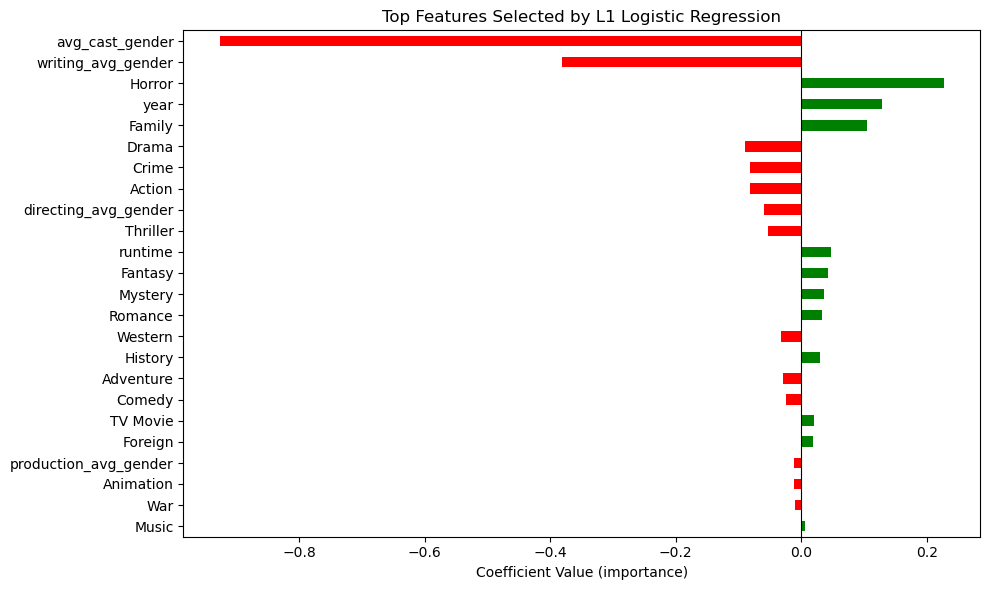

In [14]:
X = bec_results[['year', 'runtime',
        'Western', 'Romance', 'War', 'Crime', 'TV Movie',
       'Foreign', 'History', 'Thriller', 'Action', 'Horror', 'Fantasy',
       'Animation', 'Adventure', 'Mystery', 'Drama', 'Family', 'Music',
       'Comedy', 'avg_cast_gender', 'directing_avg_gender',
       'production_avg_gender', 'writing_avg_gender']]  # predictors
y = bec_results['passes_test_binary']  # binary target

# Step 1: Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Train/test split (optional, good for evaluation)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 3: Fit L1 logistic regression
model = LogisticRegression(penalty='l1', solver='liblinear', C=1.0)  # C is inverse of regularization strength
model.fit(X_train, y_train)

# Step 4: Get important features
coef = model.coef_[0]
feature_names = X.columns
important_features = pd.Series(coef, index=feature_names)
selected_features = important_features[important_features != 0]
sorted_fetures = selected_features.reindex(selected_features.abs().sort_values(ascending=False).index)

# Plot as a horizontal bar chart
plt.figure(figsize=(10, 6))
sorted_fetures.plot(kind='barh', color=np.where(sorted_fetures > 0, 'green', 'red'))

plt.title("Top Features Selected by L1 Logistic Regression")
plt.xlabel("Coefficient Value (importance)")
plt.gca().invert_yaxis()  # Most important at top
plt.axvline(0, color='black', linewidth=0.8)
plt.tight_layout()
plt.show()

This is everything, so it seems like our c value is too high. So next we tried something to get us the best value of c so we could see the most important features

In [7]:
coefficients = model.coef_[0]  # for binary classification, it's a 1D array

# Create a Pandas Series for easy inspection
coef_series = pd.Series(coefficients, index=feature_names)


excluded_features = coef_series[coef_series == 0.0]
print("Features excluded (coef = 0):")
print(excluded_features)

Features excluded (coef = 0):
Series([], dtype: float64)


In [8]:
from sklearn.linear_model import LogisticRegressionCV

model_cv = LogisticRegressionCV(
    penalty='l1',
    solver='liblinear',
    Cs=[0.01, 0.05, 0.1, 0.5, 1.0],
    cv=5,
    scoring='accuracy',
    random_state=42
)
model_cv.fit(X_scaled, y)

# View best C and selected features
print("Best C:", model_cv.C_[0])
coef_series = pd.Series(model_cv.coef_[0], index=X.columns)
print("Selected features:", coef_series[coef_series != 0.0].index.tolist())

Best C: 0.01
Selected features: ['Crime', 'Action', 'Horror', 'Family', 'avg_cast_gender', 'writing_avg_gender']


array([0.01])

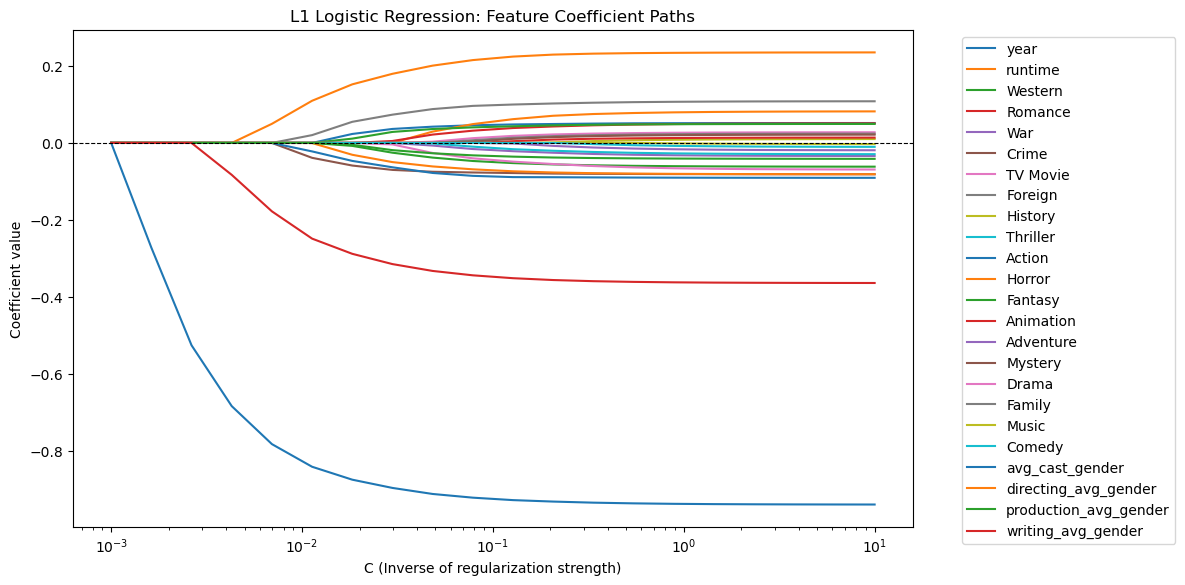

In [9]:
feature_names = X.columns

# Define a range of C values (log scale: stronger to weaker regularization)
C_values = np.logspace(-3, 1, 20)  # from 0.001 to 10

# Store coefficients
coefs = []

for C in C_values:
    model = LogisticRegression(penalty='l1', solver='liblinear', C=C, max_iter=1000)
    model.fit(X_scaled, y)
    coefs.append(model.coef_[0])

# Convert to DataFrame for plotting
coefs_df = pd.DataFrame(coefs, columns=feature_names, index=C_values)

# Plotting
plt.figure(figsize=(12, 6))
for feature in feature_names:
    plt.plot(C_values, coefs_df[feature], label=feature)

plt.xscale('log')
plt.xlabel('C (Inverse of regularization strength)')
plt.ylabel('Coefficient value')
plt.title('L1 Logistic Regression: Feature Coefficient Paths')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)
plt.tight_layout()
plt.show()

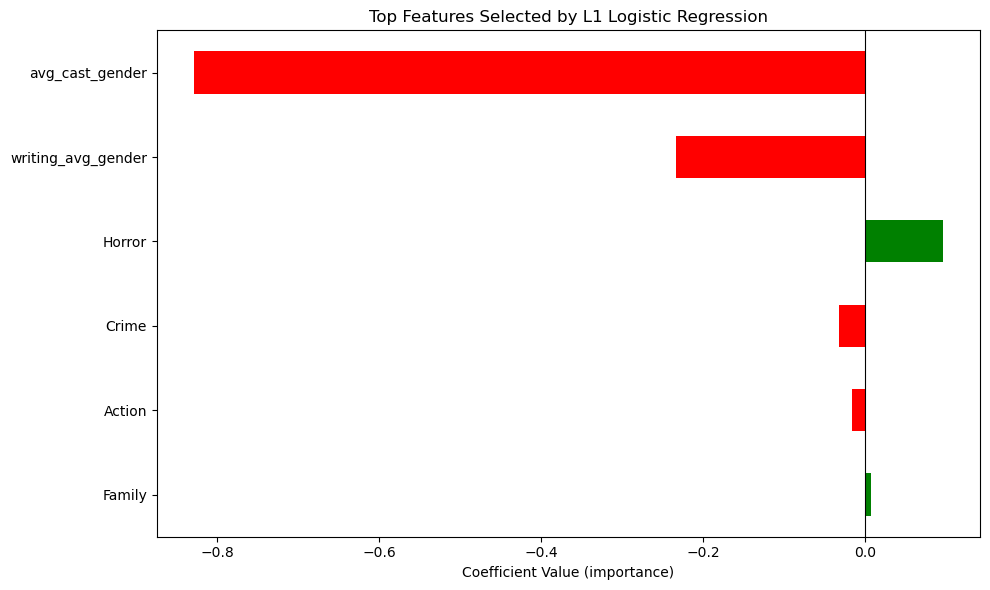

In [15]:
important_coefs = model_cv.coef_[0] 
coef_series = pd.Series(important_coefs, index=X.columns)

# Filter non-zero coefficients (selected features)
selected_coefs = coef_series[coef_series != 0]

# Sort by absolute importance
sorted_coefs = selected_coefs.reindex(selected_coefs.abs().sort_values(ascending=False).index)

# Plot as a horizontal bar chart
plt.figure(figsize=(10, 6))
sorted_coefs.plot(kind='barh', color=np.where(sorted_coefs > 0, 'green', 'red'))

plt.title("Top Features Selected by L1 Logistic Regression")
plt.xlabel("Coefficient Value (importance)")
plt.gca().invert_yaxis()  # Most important at top
plt.axvline(0, color='black', linewidth=0.8)
plt.tight_layout()
plt.show()

In [11]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred = model_cv.predict(X_scaled)
y_prob = model_cv.predict_proba(X_scaled)[:, 1]

print(classification_report(y, y_pred))
print("ROC AUC:", roc_auc_score(y, y_prob))

              precision    recall  f1-score   support

           0       0.66      0.74      0.70      1976
           1       0.74      0.67      0.70      2249

    accuracy                           0.70      4225
   macro avg       0.70      0.70      0.70      4225
weighted avg       0.71      0.70      0.70      4225

ROC AUC: 0.7718365157343884


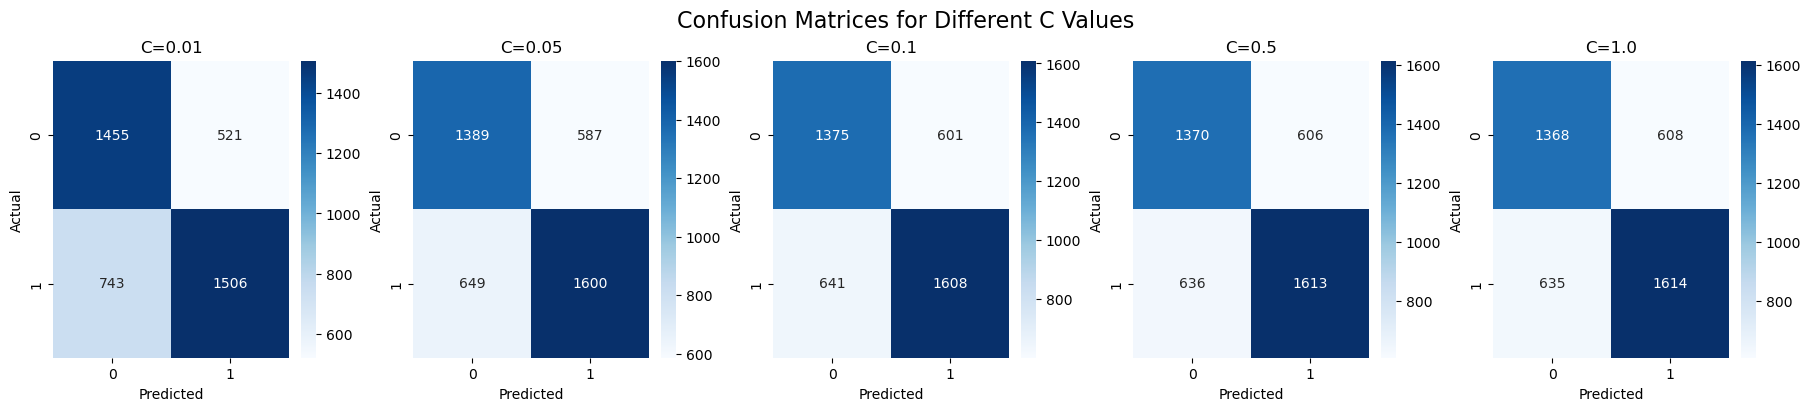

In [18]:

# Your list of C values
c_values = [0.01, 0.05, 0.1, 0.5, 1.0]

# Prepare for plotting
fig, axes = plt.subplots(1, len(c_values), figsize=(18, 4), constrained_layout=True)

# Optionally use cross-validation or just use the whole training set
for i, C in enumerate(c_values):
    model = LogisticRegression(penalty='l1', solver='liblinear', C=C)
    model.fit(X_scaled, y)
    
    y_pred = model.predict(X_scaled)
    cm = confusion_matrix(y, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'C={C}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.suptitle("Confusion Matrices for Different C Values", fontsize=16)
plt.show()